In [1]:
%matplotlib inline

In [2]:
%pwd

'/Users/shwetank/universe/Computing/courses/code/fastai/exercises'

## Unzip the training and validation files and move them to training and validation directories

In [3]:
!unzip -q ../data/train.zip -d ../data/

In [4]:
!unzip -q ../data/test.zip -d ../data/

In [5]:
!mkdir ../data/train/cat
!mkdir ../data/train/dog
!mkdir ../data/val/
!mkdir ../data/val/cat
!mkdir ../data/val/dog

In [6]:
path = "../data"
train_dir = "/train"
val_dir = "/val"
test_dir = "/test"
cat_dir = "/cat"
dog_dir = "/dog"

In [7]:
import glob
import shutil

In [8]:
all_dog_files = glob.glob(path+train_dir+"/dog.*.jpg")
all_cat_files = glob.glob(path+train_dir+"/cat.*.jpg")

In [9]:
import numpy as np

In [10]:
randomized_all_dog_files = np.random.permutation(all_dog_files)
randomized_all_cat_files = np.random.permutation(all_cat_files)
for i in range(2000): shutil.move(randomized_all_dog_files[i],path+val_dir+dog_dir)
for i in range(2000): shutil.move(randomized_all_cat_files[i],path+val_dir+cat_dir)

In [11]:
all_dog_files = glob.glob(path+train_dir+"/dog.*.jpg")
all_cat_files = glob.glob(path+train_dir+"/cat.*.jpg")
for i in range(len(all_dog_files)): shutil.move(all_dog_files[i],path+train_dir+dog_dir)
for i in range(len(all_cat_files)): shutil.move(all_cat_files[i],path+train_dir+cat_dir)

In [12]:
from matplotlib import pyplot as plt
from keras.preprocessing.image import ImageDataGenerator as IDG
import numpy as np
from utils import plot_batch

Using TensorFlow backend.


In [13]:
idg = IDG()

In [14]:
classes = ['cat','dog']
class_mode = 'binary'
batch_size = 16
path_train = path + "/train"
path_val = path + "/val"
path_test = path + "/train"
train_images = idg.flow_from_directory(path_train, batch_size=batch_size, shuffle=True, class_mode=class_mode, classes=classes)
val_images = idg.flow_from_directory(path_val, batch_size=batch_size, shuffle=True, class_mode=class_mode, classes=classes)

Found 21000 images belonging to 2 classes.
Found 4000 images belonging to 2 classes.


In [16]:
num_of_samples = len(train_images.filenames)
print(num_of_samples)

21000


In [17]:
train_batch, train_labels = train_images.next()
val_batch, val_labels = val_images.next()

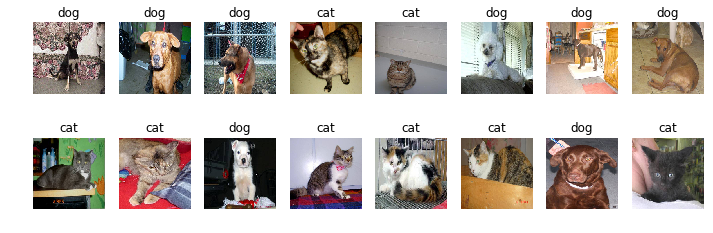

In [18]:
plot_batch(val_batch,val_labels,classes)

In [20]:
train_batch.shape

(16, 256, 256, 3)

In [21]:
from keras.applications.vgg16 import VGG16

In [24]:
image_shape = train_batch.shape[1:]
vgg16_base = VGG16(include_top=False, weights='imagenet', input_tensor=None, input_shape=image_shape, pooling=None)

In [25]:
vgg16_base.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 256, 256, 3)       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 256, 256, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 256, 256, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 128, 128, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 128, 128, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 128, 128, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 64, 64, 128)       0         
__________

In [95]:
from keras.layers import Flatten, Dense
from keras.models import Model

vgg16_top = vgg16_base.output
vgg16_top = Flatten()(vgg16_top)
# let's add a fully-connected layer
vgg16_top = Dense(1024, activation='relu')(vgg16_top)
# and a logistic layer -- let's say we have 2 classes
vgg16_top = Dense(1, activation='sigmoid')(vgg16_top)

# this is the model we will train
model = Model(inputs=vgg16_base.input, outputs=vgg16_top)

# first: train only the top layers (which were randomly initialized)
# i.e. freeze all convolutional layers
for layer in vgg16_base.layers:
    layer.trainable = False

In [96]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         (None, 256, 256, 3)       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 256, 256, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 256, 256, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 128, 128, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 128, 128, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 128, 128, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 64, 64, 128)       0         
__________

In [97]:
from keras import optimizers
model.compile(loss='binary_crossentropy',
              optimizer=optimizers.SGD(lr=1e-4, momentum=0.9),
              metrics=['accuracy'])

In [59]:
num_batches = 100./batch_size
epochs = 1
steps_per_epoch = batch_size
# fine-tune the model
model.fit_generator(train_images, steps_per_epoch=num_batches, epochs=epochs, 
                    validation_data=val_images, validation_steps=10) 

Epoch 1/1
7/6 [=================================] - 306s - loss: 1.9121 - acc: 0.8125 - val_loss: 1.2208 - val_acc: 0.8812


In [98]:
weights_file = path + '/dogs_vs_cats.h5'

In [ ]:
model.save(weights_file)

In [100]:
model.load_weights(weights_file)

In [145]:
test_images = idg.flow_from_directory(path + test_dir + "/", batch_size=1, class_mode=None, shuffle=False)
files = test_images.filenames

Found 12513 images belonging to 1 classes.


In [148]:
for n in range(0, 10):
    batch = test_images.next()
    print(model.predict(batch), files[n])

[[ 1.]] test/1.jpg
[[ 0.67614442]] test/10.jpg
[[ 0.0009127]] test/100.jpg
[[ 1.]] test/1000.jpg
[[ 1.]] test/10000.jpg
[[ 0.]] test/10001.jpg
[[  4.70003404e-14]] test/10002.jpg
[[  4.70421424e-10]] test/10003.jpg
[[ 0.]] test/10004.jpg
[[  4.40748883e-26]] test/10005.jpg
